In [175]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
%matplotlib inline

In [204]:
track = np.frombuffer(open("trackdata.f32").read(), np.float32)
track = track.reshape((4, -1))
# starting point is at 30, so rotate the track points so that it's in the front
# and also close the loop (repeat point 30 at the end)
track = np.hstack([track[:, 30:-1], track[:, 0:31]])
trackx = track[:2]
trackdx = track[2:4]

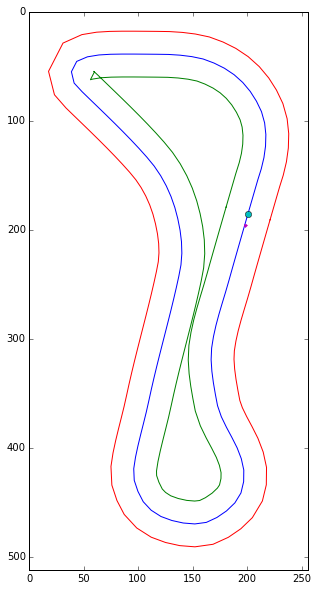

In [207]:
# review: here's what our racetrack looks like:
plt.figure(figsize=(5, 10))
plt.ylim(512, 0)
plt.xlim(0, 256)
plt.plot(trackx[0], trackx[1], '-')
leftline = trackx + 21 * np.dot([[0, -1], [1, 0]], trackdx)
rightline = trackx + 21 * np.dot([[0, 1], [-1, 0]], trackdx)
plt.plot(leftline[0], leftline[1])
plt.plot(rightline[0], rightline[1])

plt.plot(trackx[0, 0], trackx[1, 0], 'o')  # starting point
plt.plot(trackx[0, 1], trackx[1, 1], '.')  # starting direction

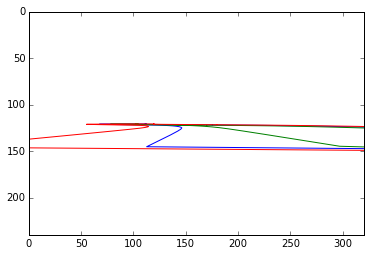

In [206]:
cam_height = 2.7
line_width = 1

def draw_view(buf, s, ey, psi):
    ''' Draw a virtual view from the car in curvilinear frame 
    s: position along the track (from 0 to len(track))
    ey: distance from centerline
    psi: angle away from centerline '''
    si = int(s)
    # we have a few different ways of rendering the centerline and the lane lines...
    # we could just use line segments, or we could do a 2nd order approx
    # or a circular one and slerp
    
    camera_matrix = np.float32([
            [100, 0, 160],
            [0, -100, 120],
            [0, 0, 1]])
    
    # TODO: interpolate
    campos = np.float32([[-track[0, si], -track[1, si], cam_height]]).T
    # get TNB frame from track gradient
    # TODO: interpolate
    T = np.vstack([track[2:4, si:si+1], [[0]]])
    N = np.dot([[0, 1, 0], [-1, 0, 0], [0, 0, 1]], T)
    B = np.float32([[0, 0, 1]]).T
    campos -= np.dot(N, ey)
    P = np.hstack([np.eye(3), campos])
    Rup = np.float32([
            [1, 0, 0],
            [0, 0, -1],
            [0, 1, 0]
        ])

    # we're gonna rotate the map so we're facing up, so T is +y and N is +x
    R = np.hstack([N, T, B]).T
    R = np.dot(cv2.Rodrigues(np.float32([0, 0, psi]))[0], R)
    # print 'R\n', R
    # we're only operating in 2D here, so B is just (0,0,1) and not used anyhow
    P = np.dot(Rup, np.dot(R, P))

    # todo: frustum clipping
    centerline = track  # track[:, si:]
    N = centerline.shape[1]
    trackdx = np.vstack([centerline[2:4], np.zeros((2, N))])
    
    RN = np.eye(4)
    RN[:2, :2] = [[0, -1], [1, 0]]
    leftline = track + 20 * np.dot(RN, trackdx)
    rightline = track + 20 * np.dot(RN.T, trackdx)

    trackx = np.vstack([centerline[0:2], np.zeros(N), np.ones(N)])  # -> homogeneous
    leftline = np.vstack([leftline[0:2], np.zeros(N), np.ones(N)])  # -> homogeneous
    rightline = np.vstack([rightline[0:2], np.zeros(N), np.ones(N)])  # -> homogeneous
    #print 'trackx\n', trackx[:3].T
    #print 'C.trackx\n', np.dot(np.hstack([np.eye(3), campos]), trackx).T
    #print 'Rup.R.trackx\n', np.dot(Rup, np.dot(R, trackx[:3])).T
    #print 'Rup.R.C.trackx\n', np.dot(np.dot(Rup, R), np.dot(np.hstack([np.eye(3), campos]), trackx)).T

    #print 'P.trackx\n', np.dot(P, trackx).T

    #leftline = trackx + 20 * np.dot([[0, -1], [1, 0]], trackdx)
    #rightline = trackx + 20 * np.dot([[0, 1], [-1, 0]], trackdx)
    #plt.plot(trackx[0], trackx[1], '-o')
    p = np.dot(camera_matrix, np.dot(P, trackx))
    pL = np.dot(camera_matrix, np.dot(P, leftline))
    pR = np.dot(camera_matrix, np.dot(P, rightline))
    p[:2] /= (p[2] + 1e-5)  # this 1e-5 is just to prevent a degenerate condition
    pL[:2] /= (pL[2] + 1e-5)
    pR[:2] /= (pR[2] + 1e-5)
    
    
    plt.xlim(0, 320)
    plt.ylim(240, 0) 
    plt.plot(p[0, p[2] > 1e-5], p[1, p[2] > 1e-5], '-')
    plt.plot(pL[0, pL[2] > 1e-5], pL[1, pL[2] > 1e-5], '-')
    plt.plot(pR[0, pR[2] > 1e-5], pR[1, pR[2] > 1e-5], '-')


draw_view(np.zeros((240, 320)), 70, -5, np.pi)


In [181]:
np.savetxt("trackdata.h", track.T, fmt="%f", delimiter=", ", newline=",\n")

In [7]:
4.75*42./74

2.695945945945946

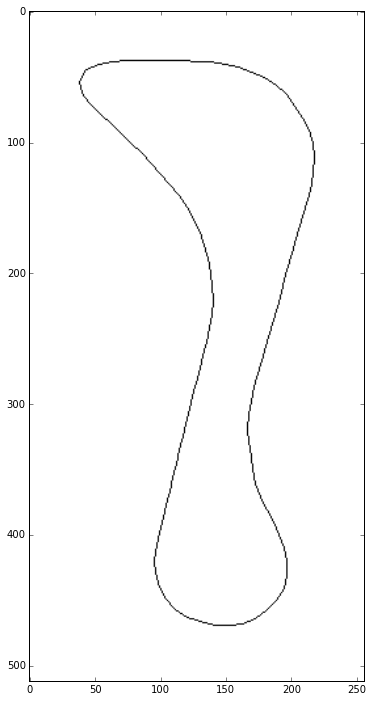

In [208]:
# Generate a distance map, so we can look up distance to the nearest line from an
# arbitrary x, y coordinate

distmap = 255*np.ones((512, 256), dtype=np.float32)
for i in range(len(track[0]) - 1):
    cv2.line(distmap,
             (int(trackx[0, i]), int(trackx[1, i])),
             (int(trackx[0, i+1]), int(trackx[1, i+1])),
             0, 1)
    
    #cv2.line(distmap,
    #         (int(leftline[0, i] + 200), int(leftline[1, i] + 300)),
    #         (int(leftline[0, i+1] + 200), int(leftline[1, i+1] + 300)),
    #         0, 1)
    #cv2.line(distmap,
    #         (int(rightline[0, i] + 200), int(rightline[1, i] + 300)),
    #         (int(rightline[0, i+1] + 200), int(rightline[1, i+1] + 300)),
    #         0, 1)

q = np.nonzero(distmap == 0)

plt.figure(figsize=(8, 12))
plt.imshow(distmap, 'gray')

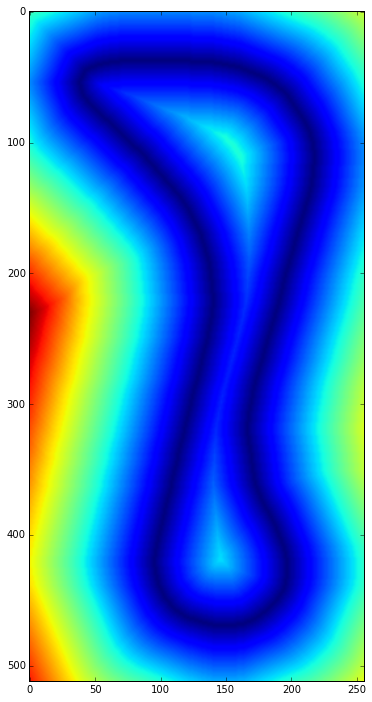

In [209]:
for i in range(100):
    distmap[:-1] = np.minimum(distmap[:-1], 1+distmap[1:])
    distmap[1:] = np.minimum(distmap[1:], 1+distmap[:-1])
    distmap[:,:-1] = np.minimum(distmap[:,:-1], 1+distmap[:,1:])
    distmap[:,1:] = np.minimum(distmap[:,1:], 1+distmap[:,:-1])

    # diagonals
    distmap[:-1, :-1] = np.minimum(distmap[:-1, :-1], np.sqrt(2)+distmap[1:, 1:])
    distmap[:-1, 1:] = np.minimum(distmap[:-1, 1:], np.sqrt(2)+distmap[1:, :-1])
    distmap[1:, :-1] = np.minimum(distmap[1:, :-1], np.sqrt(2)+distmap[:-1, 1:])
    distmap[1:, 1:] = np.minimum(distmap[1:, 1:], np.sqrt(2)+distmap[:-1, :-1])
plt.figure(figsize=(8, 12))
#plt.imshow(np.minimum(20, distmap**2), 'gray')
plt.imshow(distmap)

124.255


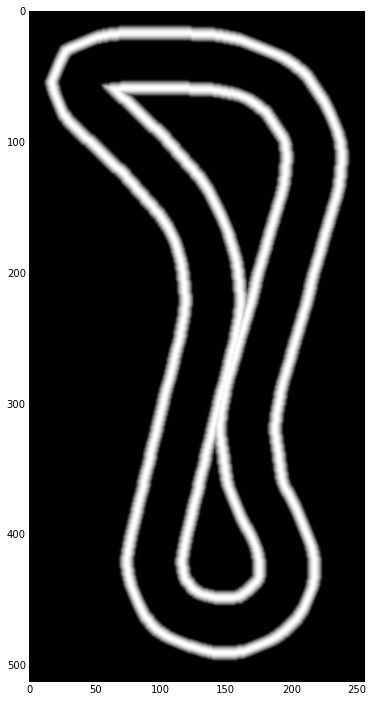

In [217]:
distmap_with_lines = np.minimum(distmap, np.abs(distmap - 21))
distmap_outer_lines = np.abs(distmap - 21)

print np.max(distmap_with_lines)
plt.figure(figsize=(8, 12))
plt.imshow(-np.minimum(40, distmap_outer_lines**2), 'gray')

In [218]:
dmap2 = (distmap_with_lines * 255.0 / np.max(distmap_with_lines)).astype(np.uint8)

# these two should have the same scale
dmap_center = (distmap * 255.0 / np.max(distmap)).astype(np.uint8)
dmap_outer = (distmap_outer_lines * 255.0 / np.max(distmap)).astype(np.uint8)

In [212]:
dmap[200, 246]

60

In [219]:
cv2.imwrite("distmapy.png", dmap_center)
cv2.imwrite("distmapw.png", dmap_outer)

True

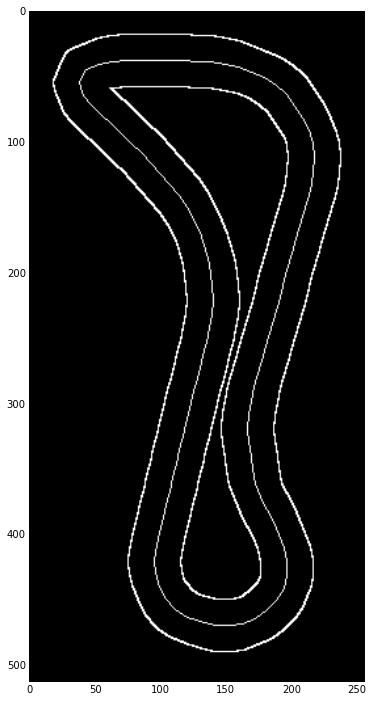

In [202]:
plt.figure(figsize=(8, 12))
plt.imshow(dmap < 2, 'gray')